# Import libraries

In [1]:
from __future__ import division, print_function

import os
import numpy as np
import math
from math import pi
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import clear_output

from library import *
# %matplotlib notebook

# Settings

Setting the model parameter range and mesh settings for the computation of global frequency and stability eigenvalues.

In [2]:
# Set fixed parameters
g = 1.5
w0 = 1.0
T = 0.1
gain = 30
inj = 0
delta = 0.05
bara = 1 - inj
sigma = bara
v_fac = 5

# Parameter range (for Omega)
T_range = [0, 1]
gain_range = [0, 40]

# Numerical settings
T_steps = 20
gain_steps = 20

# Real and imaginary range (for eigenvalues)
re_range = [-6,6]
re_steps = 100
im_steps = 100

# Global Frequency

Computes the meshes for the global frequency.

## Directory

Create save directories. If the mesh files already exist in a directory, you can skip to Plots.

In [3]:
# Save directory for arrays
folder_Omega = 'Fig2_dataset'
name_Omega = 'delta1.mat'
dir_Omega = os.path.join(os.getcwd(), 'data', folder_Omega)

# Create directory if it doesn't exist:
if not os.path.exists(dir_Omega):
    os.makedirs(dir_Omega)

## Computation of meshes

In [4]:
# Define T, gain meshes
T_part = np.linspace(T_range[0], T_range[1], T_steps+1)
T_part = T_part[1:]
gain_part = np.linspace(gain_range[0], gain_range[1], gain_steps+1)
gain_part = gain_part[1:]
gain_mesh, T_mesh = np.meshgrid(gain_part, T_part)

# Define Omega mesh
Omega_mesh = np.zeros((T_steps, gain_steps))

# Fill Omega mesh with closest values:
for i in range(T_steps):
    for j in range(gain_steps):
        T = T_part[i]
        gain = gain_part[j]
        f = fun_pack.Omega_infty(g, w0, bara, T, gain, delta)
        f0 = lambda u: f(u) - u
        
        # Closest root to w0:
        Omega_root = eig_pack.closest_root(f0, w0, [w0-2*g*bara,w0+2*g*bara], part=20)
        
        if Omega_root.status == 'Exists':
            Omega_mesh[i,j] = Omega_root.x
        
        else:
            Omega_mesh[i,j] = 0

## Export 

Exports the meshes Omega_mesh, gain_mesh, T_mesh computed above to directory dir_Omega.
The meshes are combined into a single .mat file under the keys 'Omega', 'gain', 'T' respectively.

In [5]:
# Define dictionary
Omega_dict = {'Omega': Omega_mesh,
              'gain': gain_mesh,
              'T': T_mesh,
              'w0': w0
             }

# Export dictionary as a single .mat file
Omega_filename = os.path.join(dir_Omega, name_Omega)
sio.savemat(Omega_filename, Omega_dict)

# Eigenvalues

Computes the meshes for the stability eigenvalues for both non-plastic and plastic delays.

## Directory

Create save directories. If the mesh files already exist in a directory, you can skip to Plots.

In [6]:
# Save directory for arrays
folder_eig = 'Fig2_dataset'
name_eig_noplas = 'noplas.mat'
name_eig_plas = 'plas.mat'

dir_eig = os.path.join(os.getcwd(), 'data', folder_eig)

# Create directory if it doesn't exist:
if not os.path.exists(dir_eig):
    os.makedirs(dir_eig)

## Computation of meshes

In [7]:
# Obtain global frequency
f2 = fun_pack.Omega_infty(g, w0, 1 - inj, T, gain, 0)
f_Omega = lambda u: f2(u) - u

# Closest root to w0:
Omega0_root = eig_pack.closest_root(f_Omega, w0, [w0-g*bara,w0+g*bara], part=20)

if Omega0_root.status == 'Exists':
    Omega = Omega0_root.x

# Define function, rect, part
eig_f_noplas = fun_pack.eig_infty(g, Omega, T, bara, sigma, plas=False)
eig_f_plas = fun_pack.eig_infty(g, Omega, T, bara, sigma, plas=True)

f_noplas = lambda u: eig_f_noplas(u) - u
f_plas = lambda u: eig_f_plas(u) - u

region = np.array([re_range, [-v_fac*g*(1-inj), v_fac*g*(1-inj)]])
partition = (re_steps, im_steps)

roots_err_noplas = eig_pack.root_mesh(f_noplas, region, parts=partition, root='all')
roots_err_plas = eig_pack.root_mesh(f_plas, region, parts=partition, root='all')

base_eig_noplas = fun_pack.eig_base(Omega, g, bara, T, plas=False)
base_eig_plas = fun_pack.eig_base(Omega, g, bara, T, plas=True)

base_eig_re = base_eig_noplas.real
base_eig_re = base_eig_plas.real

## Export

In [8]:
# Define dictionary
eig_noplas_dict = {'err': np.abs(roots_err_noplas.f_mesh),
                     'u': roots_err_noplas.u_mesh,
                     'v': roots_err_noplas.v_mesh,
                   'base': base_eig_re
                  }

eig_plas_dict = {'err': np.abs(roots_err_plas.f_mesh),
                     'u': roots_err_plas.u_mesh,
                     'v': roots_err_plas.v_mesh,
                   'base': base_eig_re
                  }

# Export dictionary as a single .mat file
eig_noplas_filename = os.path.join(dir_eig, name_eig_noplas)
eig_plas_filename = os.path.join(dir_eig, name_eig_plas)
sio.savemat(eig_noplas_filename, eig_noplas_dict)
sio.savemat(eig_plas_filename, eig_plas_dict)

# Plots

Script for 3D surface plots using the meshes computed above. All plots are generated without labels.

## Global Frequency

(0, array([[1.]]))

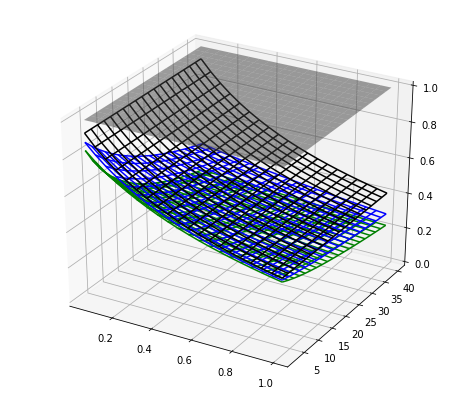

In [9]:
# Directory and files to import from
folder_Omega = 'Fig2_dataset'
file_list = ['delta0.mat', 'delta1.mat', 'delta2.mat']
color_list = ['black', 'blue', 'green']

dir_Omega = os.path.join(os.getcwd(), 'data', folder_Omega)


# Figure
fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3d plot for each file in file_list:
for i in range(len(file_list)):
    Omega_file = file_list[i]
    
    # Import meshes
    Omega_mat = sio.loadmat(os.path.join(dir_Omega, Omega_file))
    
    Omega_mesh = Omega_mat['Omega']
    gain_mesh = Omega_mat['gain']
    T_mesh = Omega_mat['T']
    
    # Plot surface
    ax.plot_wireframe(T_mesh, gain_mesh, Omega_mesh, color=color_list[i])

# Plot w0:
w0 = Omega_mat['w0']
w0_mesh = w0*np.ones(T_mesh.shape)
ax.plot_surface(T_mesh, gain_mesh, w0_mesh, color='grey', alpha=0.5)

# Figure options
ax.set_zlim(0, w0)

## Eigenvalues

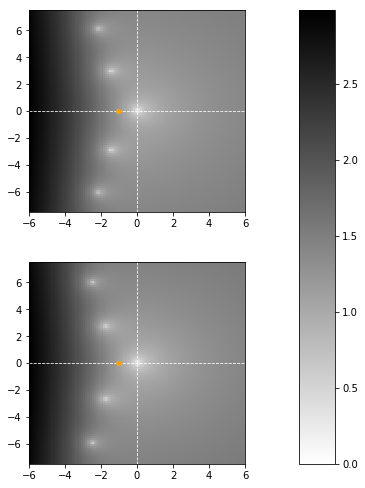

In [10]:
# Directory and files to import from
folder_eig = 'Fig2_dataset'
file_noplas = 'noplas.mat'
file_plas = 'plas.mat'

dir_eig = os.path.join(os.getcwd(), 'data', folder_eig)
dir_noplas = os.path.join(dir_eig, file_noplas)
dir_plas = os.path.join(dir_eig, file_plas)

# Import .mat files
dict_noplas = sio.loadmat(dir_noplas)
dict_plas = sio.loadmat(dir_plas)

# Figure and ax:
fig, ax = plt.subplots(3, figsize=(5,7))

# Configure size and position of each ax
Bbox = plot_pack.heatmap_positions()
for j in range(3):
    ax[j].set_position(Bbox[j])

ax[2].set_frame_on('False')

# Top (plastic):
plot_pack.plot_heatmap(dict_noplas, ax[1])

# Bottom (plastic):
c = plot_pack.plot_heatmap(dict_plas, ax[0])

fig.colorbar(c, cax=ax[2]) 